In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import sigpy as sp
import sigpy.plot as pl
import seaborn as sns
sns.set(style='darkgrid', palette='Set2')
from cmcrameri import cm

import sys
sys.path.append("/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

In [2]:
from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np

allsubj = np.zeros((128,128,6,4,5,2,1),dtype = 'complex')
mask_all = np.zeros((128,128,6,2,1)) #X, Y, Volunteer #, Slice #

cut = 20
filt = np.concatenate((np.zeros((cut,100-cut*2)),np.ones((128-cut*2,100-cut*2)),np.zeros((cut,100-cut*2))))
filt = np.concatenate((np.zeros((128,cut)),filt,np.zeros(((128,cut)))),axis = -1)

M0_mag = np.zeros((128,100,3,4,5,10))
M1_mag = np.zeros((128,100,3,4,5,10))
M2_mag = np.zeros((128,100,3,4,5,10))

M0_phs = np.zeros((128,100,3,4,5,10))
M1_phs = np.zeros((128,100,3,4,5,10))
M2_phs = np.zeros((128,100,3,4,5,10))

M0_mask = np.zeros((128,100,3,4,5,10))
M1_mask = np.zeros((128,100,3,4,5,10))
M2_mask = np.zeros((128,100,3,4,5,10))

M0_adc_avg = np.zeros((128,100,3,10))
M1_adc_avg = np.zeros((128,100,3,10))
M2_adc_avg = np.zeros((128,100,3,10))



count = 0
for vv in range(1,11):
    print(vv)
    volunteer = str(vv)
    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
    inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Heart/V00' + volunteer + '/DWI'

    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])
    
    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()

    
    mask_files_LV = [_ for _ in os.listdir(inpath) if _.startswith('LV')]
    mask_files_BP = [_ for _ in os.listdir(inpath) if _.startswith('BP')]
    
    mask_files_LV.sort()
    mask_files_BP.sort()

    mm = 0
    for num in range(1,7,2):
    
    # inpath = '/Volumes/T7/phase_paper/Heart/V00' + volunteer + '/DWI'
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        
        mask_LV,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_LV[mm]), return_voxsize=True)
        mask_BP,affine, voxsize = load_nifti(os.path.join(inpath, mask_files_BP[mm]), return_voxsize=True)
    
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)

        ims = data1
        mag = abs(ims)
        phs = np.angle(ims)
        
        mask_LV_rep = np.tile(mask_LV[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_BP_rep = np.tile(mask_BP[:,:,:,np.newaxis,np.newaxis],(1,1,1,4,5))
        mask_rep = (mask_LV_rep - mask_BP_rep).astype(np.float32)
        
        mask_rep[mask_rep ==0] = np.nan
        adc_avg = DWI_recon(mag,bvals_sort,bvecs_sort)
        
        
        im = mag * np.exp(1j*phs)
       
        
        if mag.shape[0] == 100:
            print('Dim',vv)
            mag = mag.transpose(1,0,2,3,4)
            phs = phs.transpose(1,0,2,3,4)
            mask_rep = mask_rep.transpose(1,0,2,3,4)
            adc_avg[0]['ADC'] = adc_avg[0]['ADC'].transpose(1,0,2)

        
        if num == 1:
            M0_mag[:,:,:,:,:,count] = mag #* mask_rep
            M0_phs[:,:,:,:,:,count] = phs #*mask_rep
            M0_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M0_adc_avg[:,:,:,count] = adc_avg[0]['ADC']

            
            
            
        if num == 3:
            M1_mag[:,:,:,:,:,count] = mag #* mask_rep
            M1_phs[:,:,:,:,:,count] = phs #*mask_rep
            M1_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M1_adc_avg[:,:,:,count] = adc_avg[0]['ADC']

        if num == 5:
            M2_mag[:,:,:,:,:,count] = mag #* mask_rep
            M2_phs[:,:,:,:,:,count] = phs #*mask_rep
            M2_mask[:,:,:,:,:,count] = mask_rep #*mask_rep
            M2_adc_avg[:,:,:,count] = adc_avg[0]['ADC']
           
        mm = mm +1
    count = count + 1

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


1


/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: invalid value encountered in divide
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Code/cDTI_python/mystic_mrpy/Diffusion/DWI.py:45: RuntimeWarning: divide by zero encountered in log
  D_xx                             = -(1 / b) * np.log(S_x / S_0)                                                             # Calculate x diffusion coefficient
/Users/arielhannum/Documents/Stanford/CMR-Setsompop/C

2
Dim 2
Dim 2
Dim 2
3
4
5
Dim 5
Dim 5
Dim 5
6
7
8
9
10
Dim 10
Dim 10
Dim 10


In [3]:

M0_adj = (np.exp(1j*M0_phs)) / np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M1_adj = (np.exp(1j*M1_phs)) / np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M2_adj = (np.exp(1j*M2_phs)) / np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
print(M0_adj.shape)

M0_diff = np.angle(M0_adj / np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M1_diff = np.angle(M1_adj / np.tile(np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M2_diff = np.angle(M2_adj / np.tile(np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
print(M0_diff.shape)

phs_diff_all = np.stack((np.angle(M0_diff),np.angle(M1_diff),np.angle(M2_diff)))
print(phs_diff_all.shape)

num_M0 =  M0_diff * (M0_adj * np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))

M0_std = np.sqrt(np.sum(M0_diff**2,axis = -2)/5)
M1_std = np.sqrt(np.sum(M1_diff**2,axis = -2)/5)
M2_std = np.sqrt(np.sum(M2_diff**2,axis = -2)/5)
print(M0_std.shape)

(128, 100, 3, 4, 5, 10)
(128, 100, 3, 4, 5, 10)
(3, 128, 100, 3, 4, 5, 10)
(128, 100, 3, 4, 10)


In [4]:
M0_mask.shape

(128, 100, 3, 4, 5, 10)

In [5]:
M0_std_mean = np.nanmean(M0_std*M0_mask[:,:,:,:,0,:], axis = (0,1))
M1_std_mean = np.nanmean(M1_std*M1_mask[:,:,:,:,0,:], axis = (0,1))
M2_std_mean = np.nanmean(M2_std*M2_mask[:,:,:,:,0,:], axis = (0,1))

std_all = np.stack((M0_std_mean,M1_std_mean,M2_std_mean),axis = -1)
print(std_all.shape)

(3, 4, 10, 3)


In [6]:
import pandas as pd

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

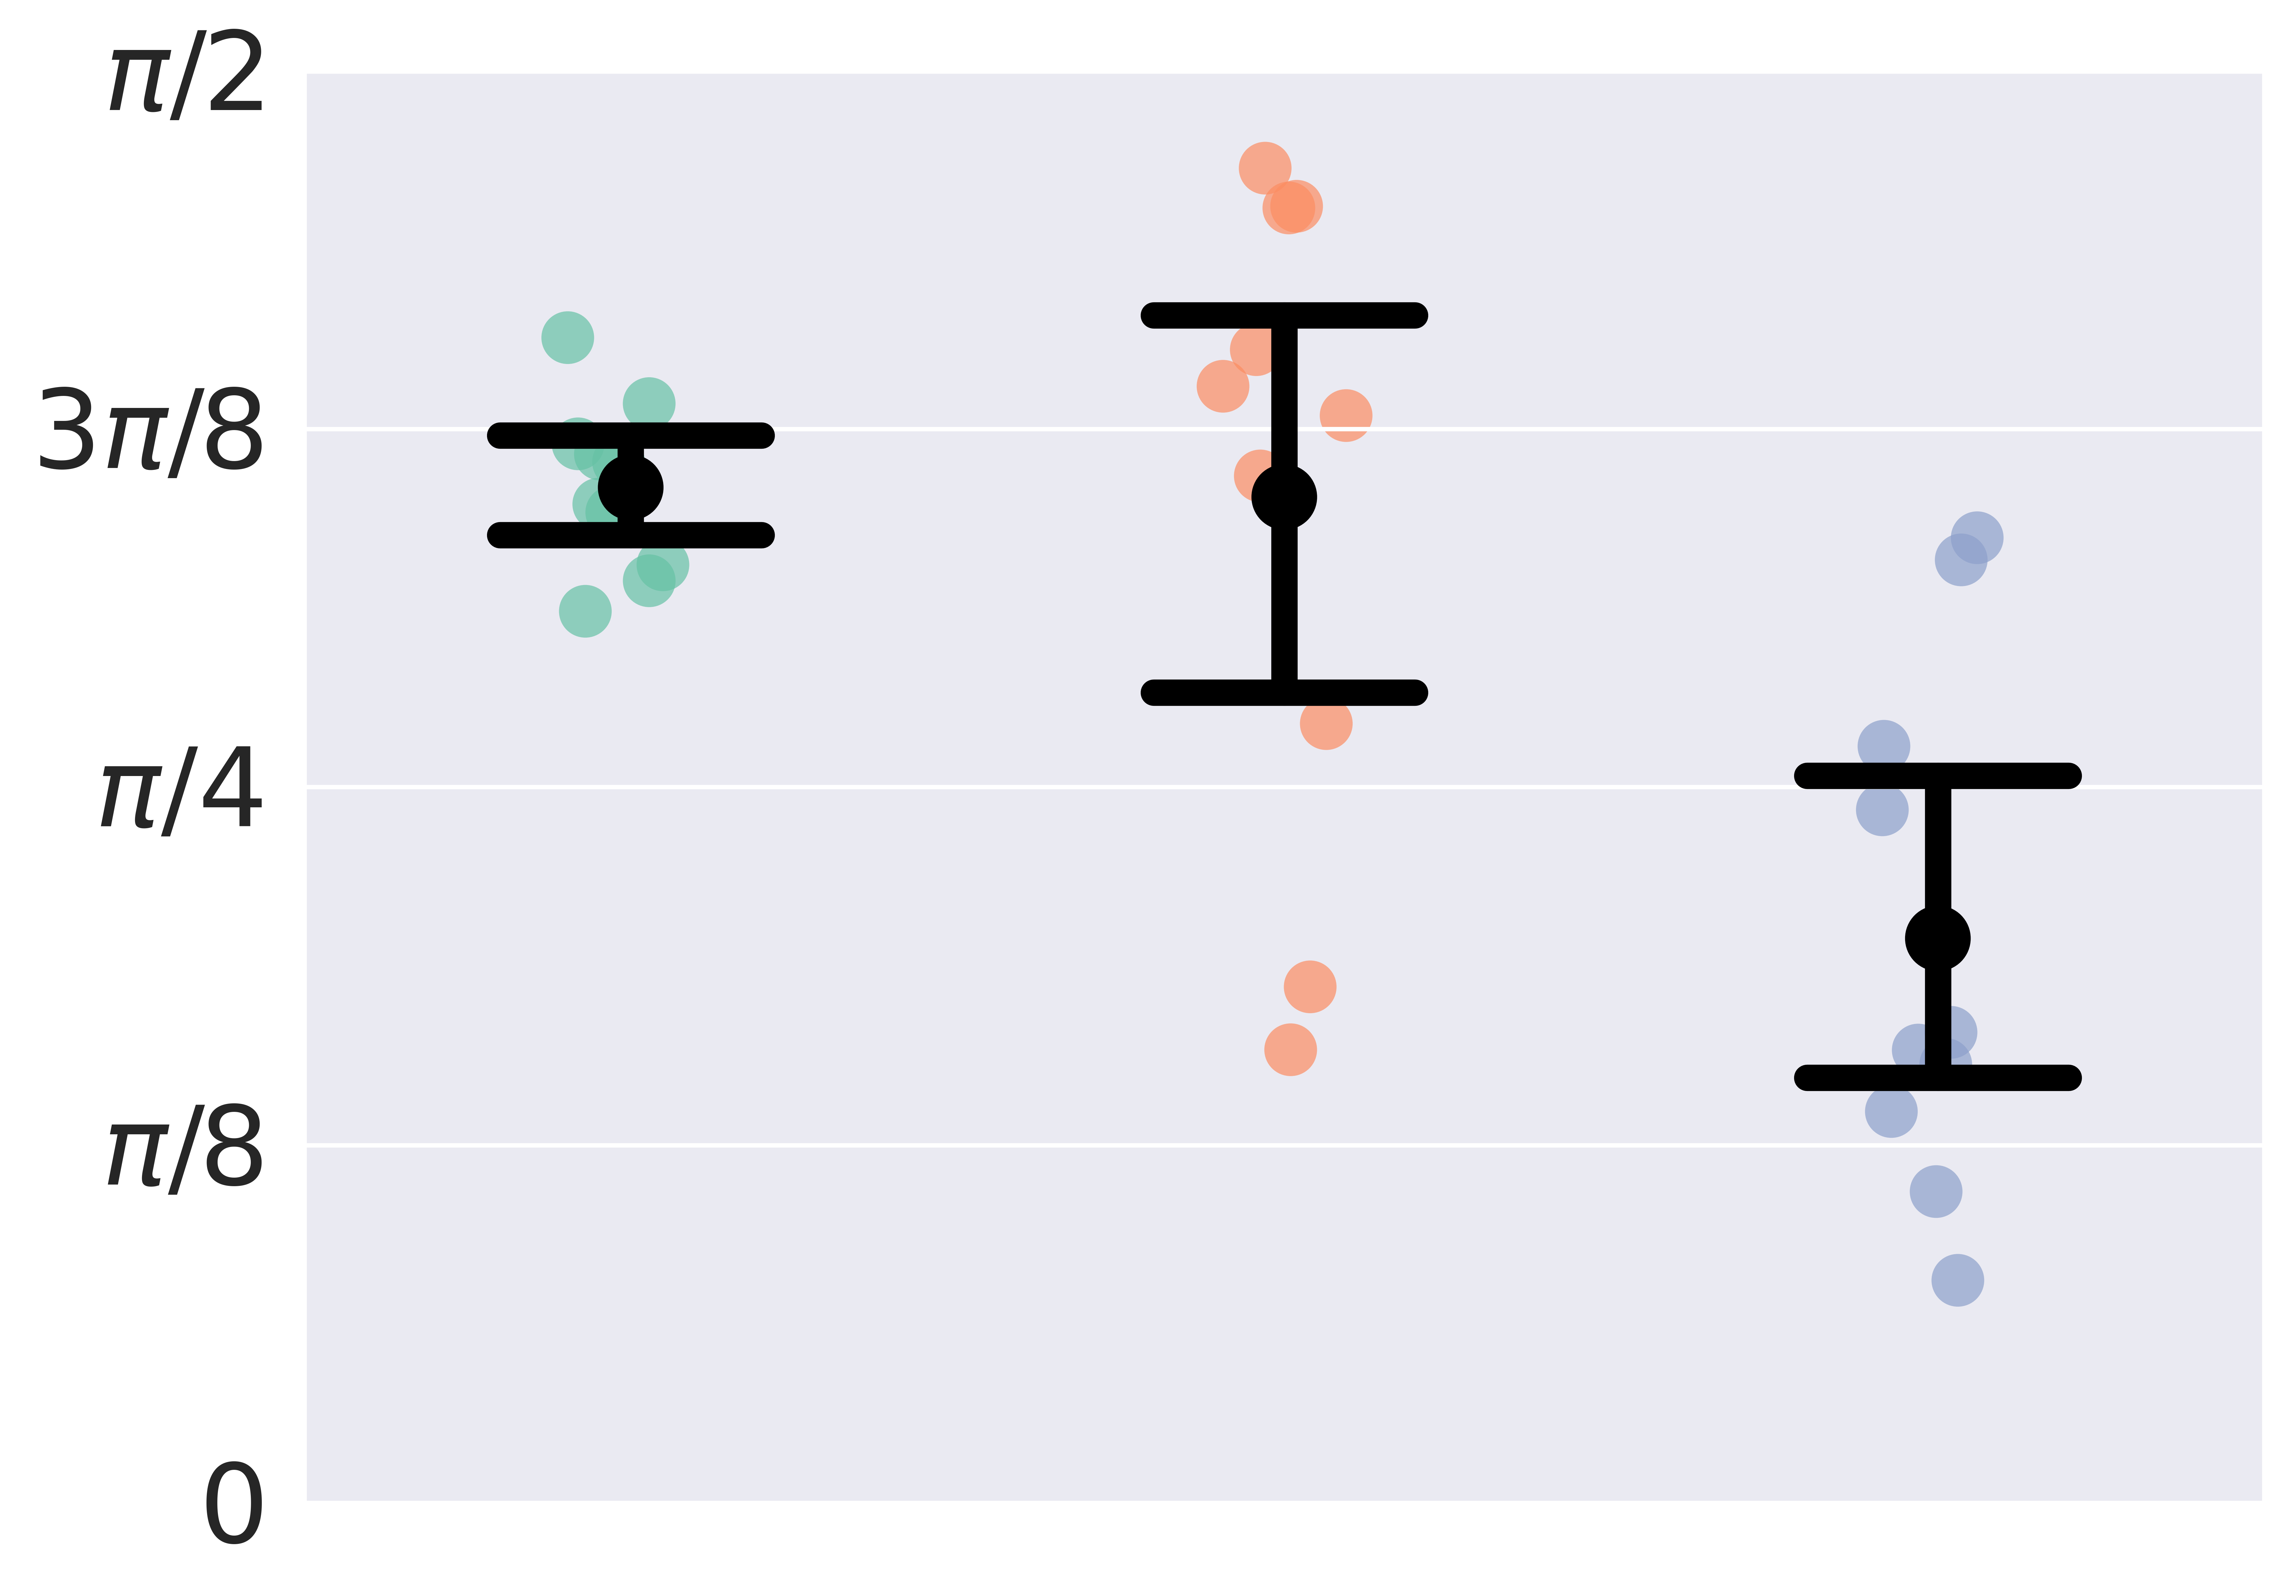

In [7]:

dd = 3
sl = 1

data = pd.DataFrame(std_all[sl,dd,:,:])

fig, axes = plt.subplots(1, 1, figsize=(8,6),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [0,1,2]



axes.set_xticks([0,1,2])
axes.set_xticklabels(['1','2','3'],size = 1,color='white')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.tick_params(axis='x', which='major', labelsize=35)
axes.set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
axes.set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
axes.set_ylim([0,math.pi/2])
axes.set_xlim([-0.2,2.2])
axes.set_xticks([0,1,2])
axes.set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
        
sns.stripplot(data=data,color = 'black',
    size = 12,zorder = 0,edgecolor='gray', ax = axes,palette='Set2',alpha = 0.7)


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7,
    errorbar=("se",data), capsize=.4, join=False, orient ='v',ax=axes,
)






In [8]:

dd = 1
sl = 2



fig, axes = plt.subplots(3, 4, figsize=(15,10),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [2,1,0]


for dd in range(4):
    for sl in range(3):
        data = pd.DataFrame(std_all[slices[sl],dd,:,:])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels(['1','2','3'],size = 1,color='white')
        axes[sl,dd].tick_params(axis='y', which='major', labelsize=35)
        axes[sl,dd].tick_params(axis='x', which='major', labelsize=35)
        axes[sl,dd].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
        axes[sl,dd].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
        axes[sl,dd].set_ylim([0,math.pi/2])
        axes[sl,dd].set_xlim([-0.2,2.2])
        axes[sl,dd].set_xticks([0,1,2])
        axes[sl,dd].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
                
        sns.swarmplot(data=data,color = 'black',
            size = 12,zorder = 0,edgecolor='gray', ax = axes[sl,dd],palette='Set2',alpha = 0.7)


        sns.pointplot(
            data=data,color = 'black',errwidth=6,scale = 1.7,
            errorbar=("se",data), capsize=.4, join=False, orient ='v',ax=axes[sl,dd],
        )

plt.subplots_adjust(wspace=0.05, hspace=0.15)  
plt.show()





/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/arielhannum/opt

In [20]:
std_all.shape


(3, 4, 10, 3)

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


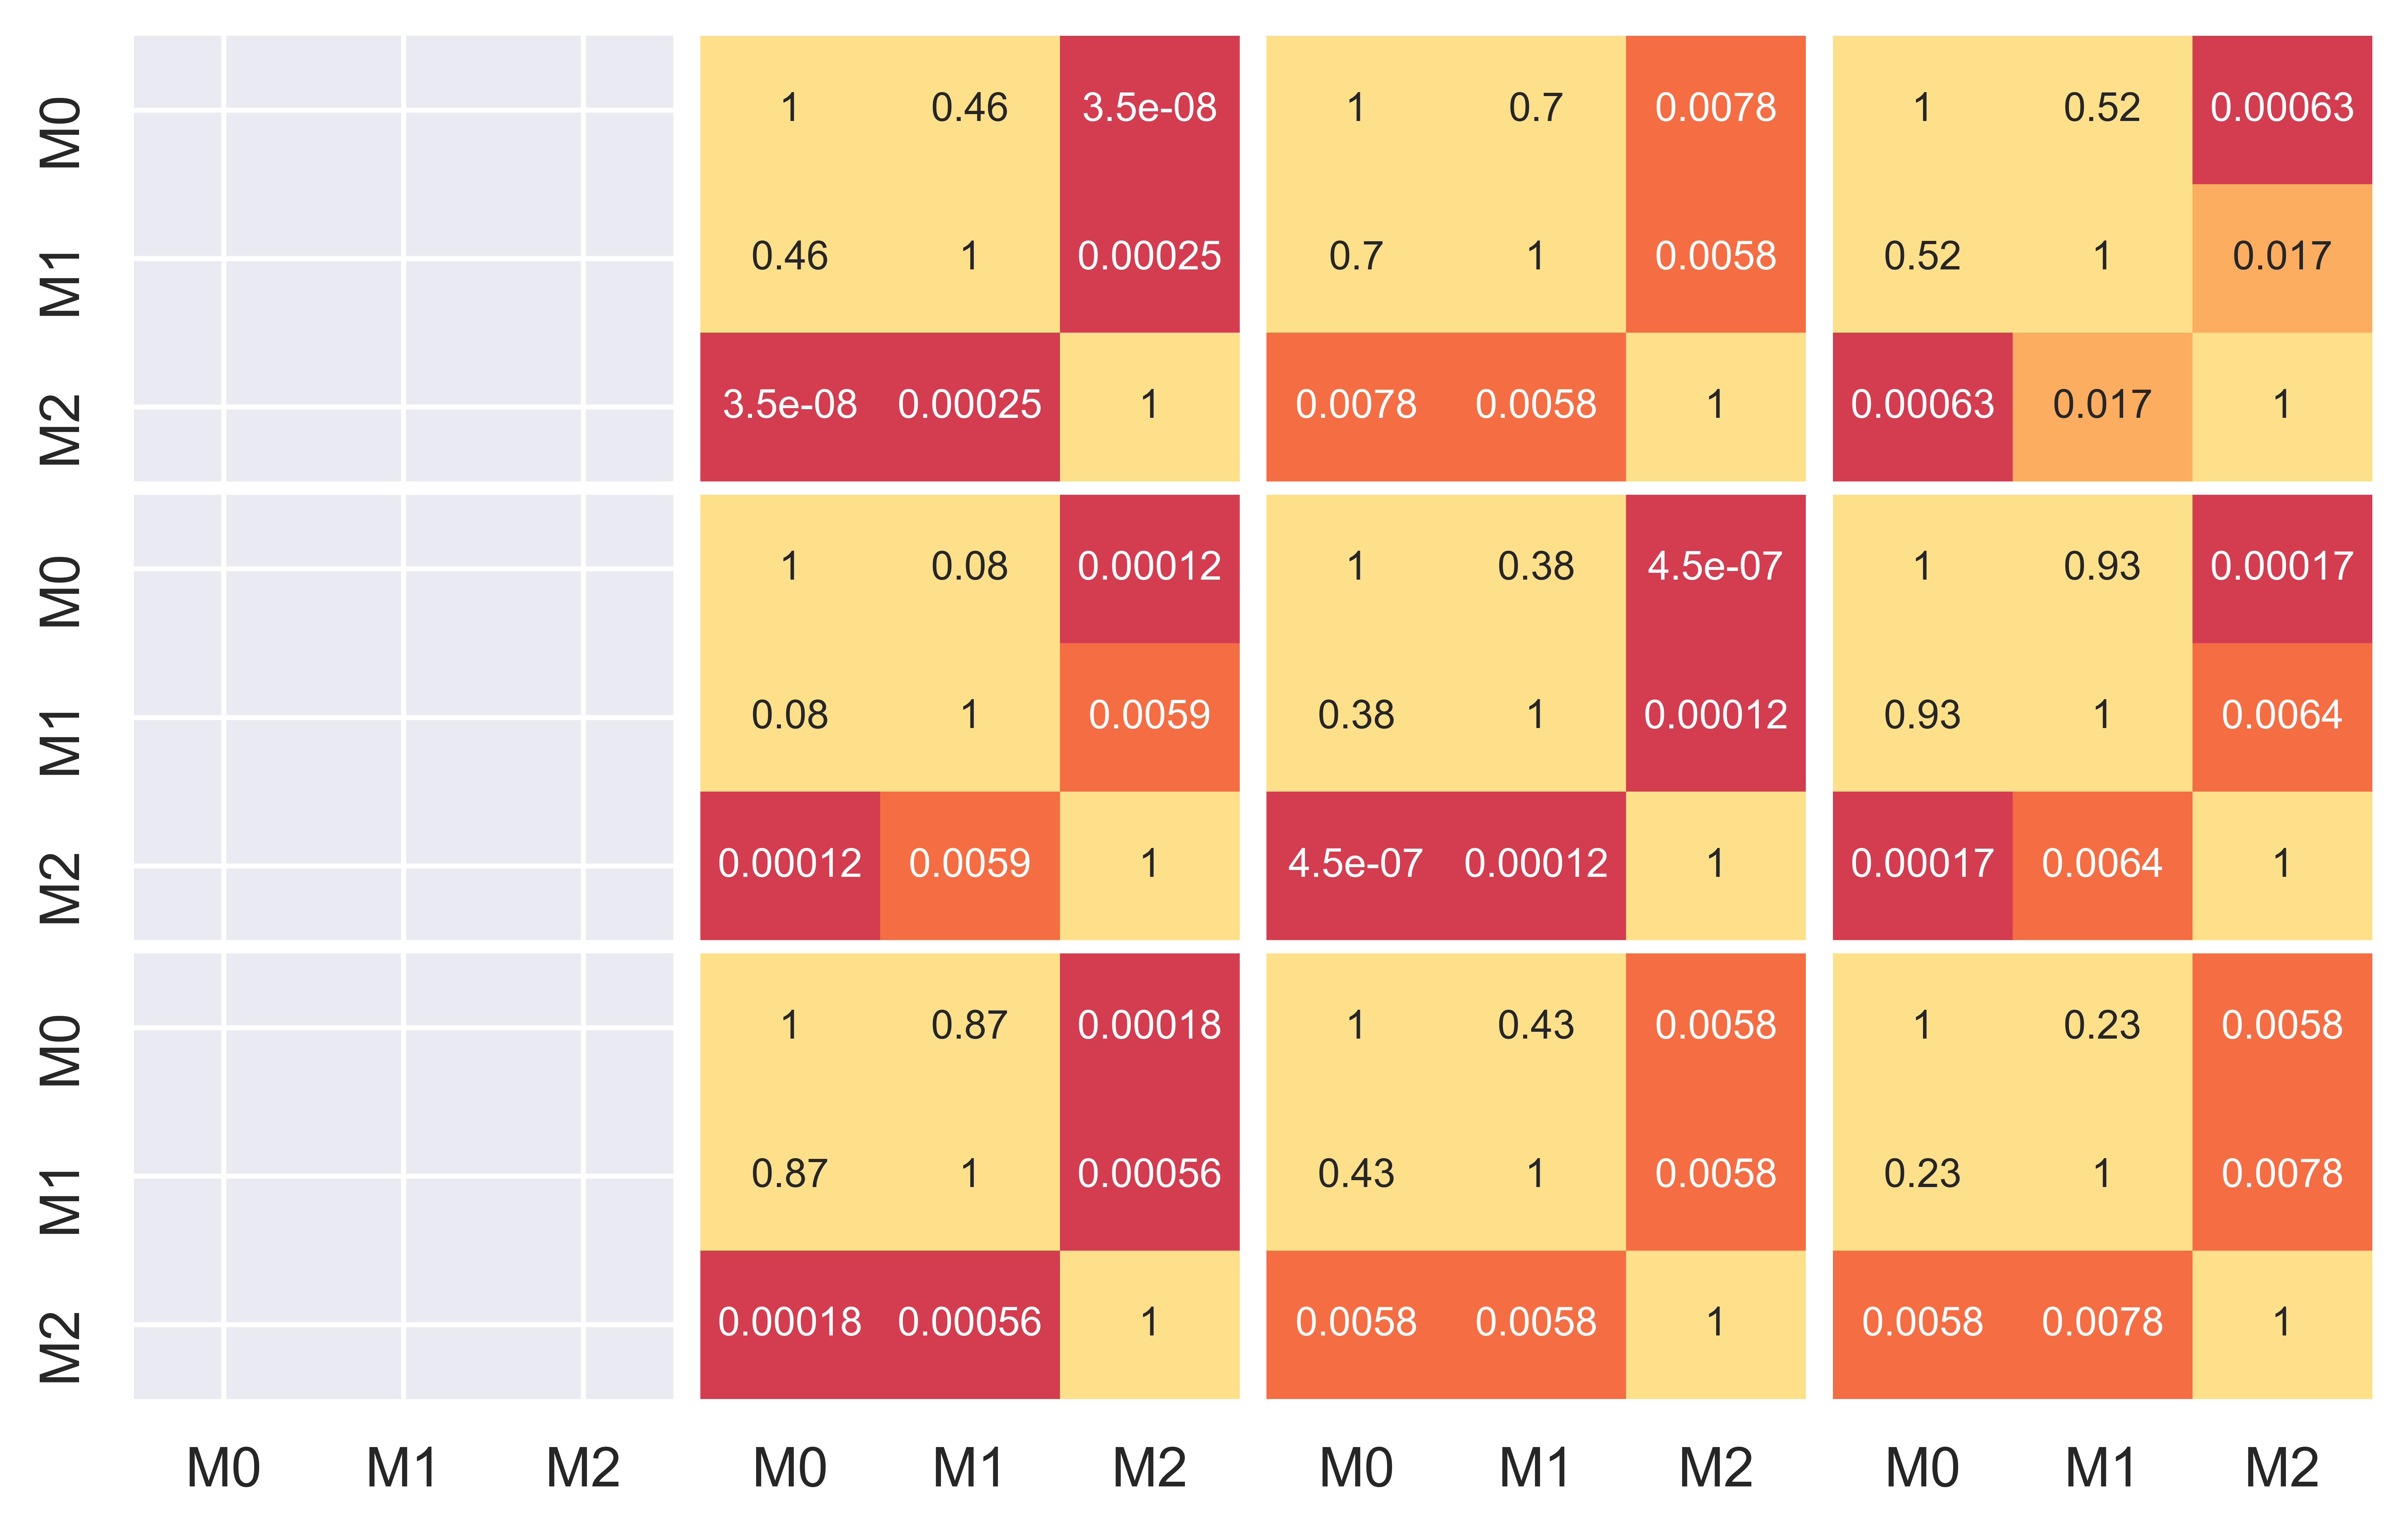

In [21]:
# Looking at Confidence intervals of the phase differences seeing if there is significant decrease with increasing motion compensation
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,3,3))
hypothesis[:] = np.nan

slices = [2,1,0]
for sl in range(3):
    for dd in range(4):
        group1 = std_all[slices[sl],dd,:,0]
        group2 = std_all[slices[sl],dd,:,1]
        group3 = std_all[slices[sl],dd,:,2]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)




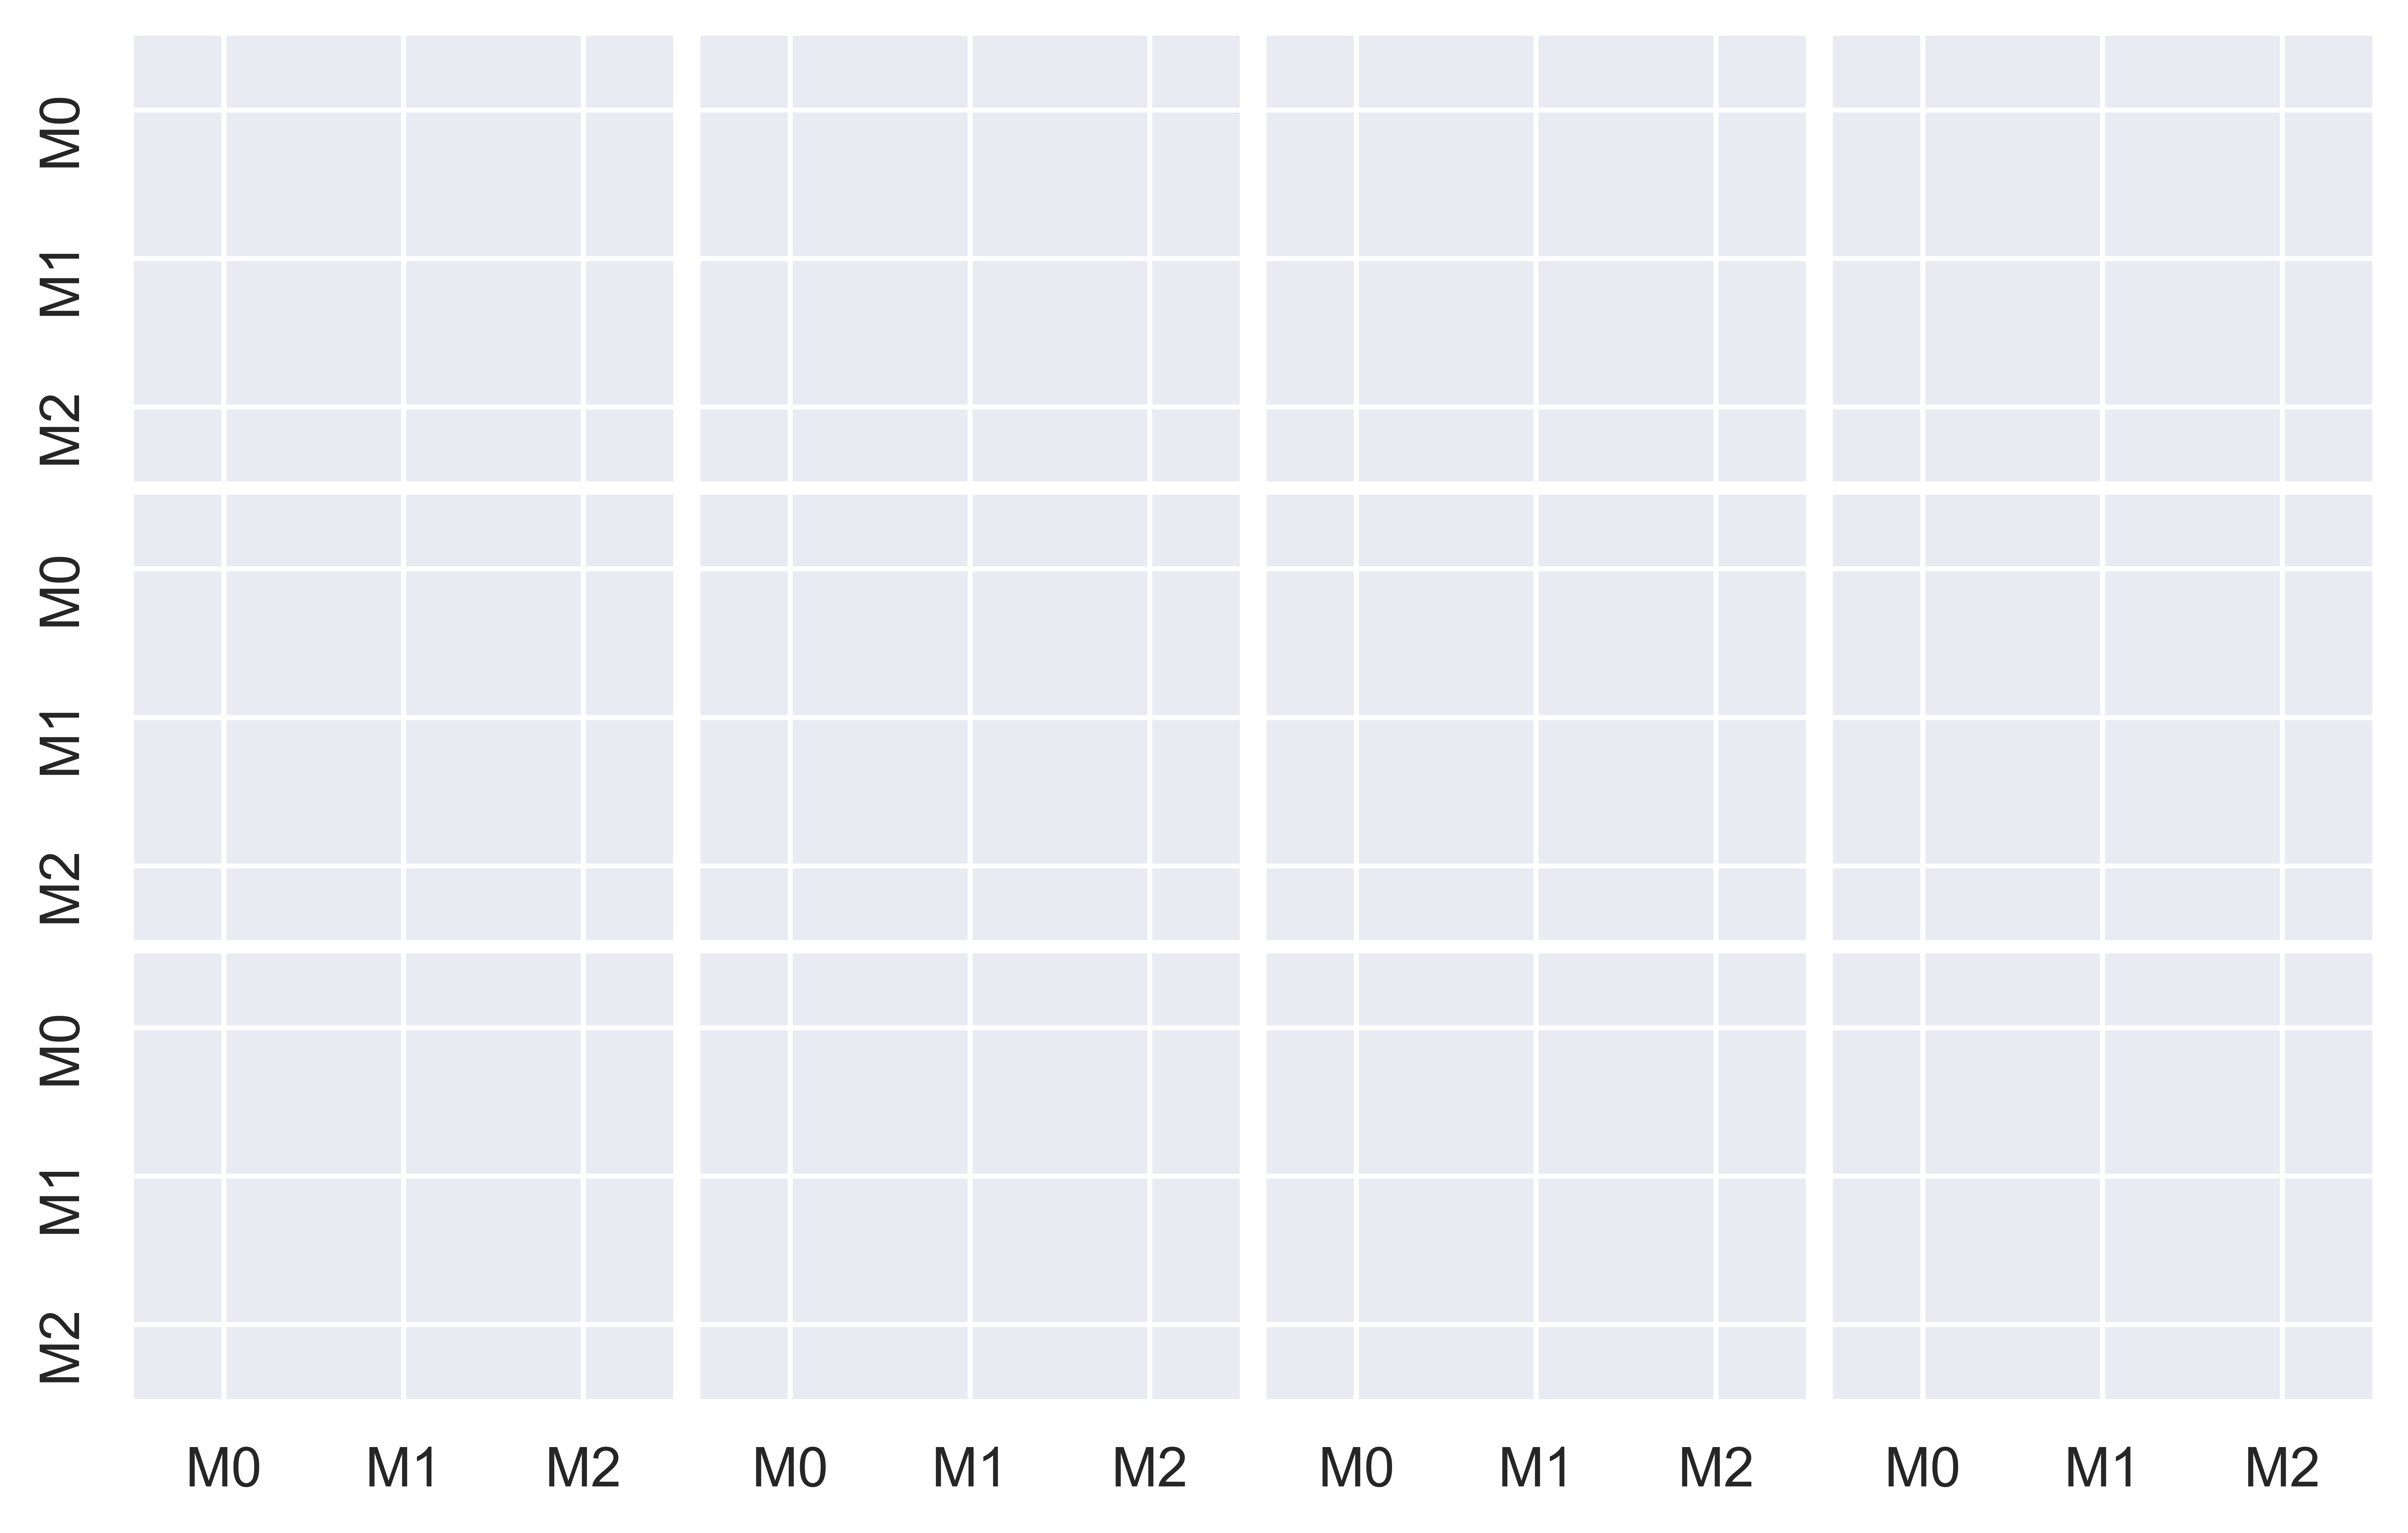

In [ ]:
# Looking at signifiance between slices 
import scikit_posthocs as sp
from scipy import stats
alpha= 0.05

hypothesis = np.zeros((3,4,3,3))
hypothesis[:] = np.nan

slices = [2,1,0]
for sl in range(3):
    for dd in range(4):
        group1 = std_all[0,dd,:,sl]
        group2 = std_all[1,dd,:,sl]
        group3 = std_all[2,dd,:, sl]

        normal = 0 if stats.shapiro(group1)[1] <alpha or stats.shapiro(group2)[1] <alpha or stats.shapiro(group1)[1] <alpha else 1

        if normal ==0:
            result = stats.friedmanchisquare(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_wilcoxon([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test
            else:
                hypothesis[sl,dd,:,:] = np.nan

        elif normal ==1:
            result = stats.f_oneway(group1, group2, group3)
            if result[1] < alpha:
                test = sp.posthoc_ttest([group1,group2,group3],p_adjust = 'holm-sidak')
                hypothesis[sl,dd,:,:] = test 
            else:
                hypothesis[sl,dd,:,:] = np.nan



from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import numpy as np

my_colors = [sns.color_palette("Spectral",9)[0], sns.color_palette("Spectral",9)[1], sns.color_palette("Spectral",9)[2], 
            sns.color_palette("Spectral",9)[3]]
my_cmap = ListedColormap(my_colors)
bounds = [0, 0.001, 0.01, 0.05,1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

fig, axes = plt.subplots(3, 4, figsize=(8,5),sharex=True,sharey = True,dpi=1000)
count = 2
for sl in range(3):
    for dirs in range(4):
        ax=sns.heatmap(hypothesis[count,dirs,:,:],ax = axes[sl,dirs], annot = True, xticklabels=['M0','M1','M2'],
                    yticklabels=['M0','M1','M2'],norm=my_norm,cmap = my_cmap,cbar = False,annot_kws={"fontsize":8})
        #c_bar = ax.collections[0].colorbar
        #c_bar.set_ticks([(0 + 0.001)/2,(0.001+0.01)/2,(0.01+0.05)/2,(0.05+1)/2])
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  
        #c_bar.set_ticklabels(['p<0.001','p<0.01','p<0.05','n.s.'])  


    count = count -1

plt.subplots_adjust(wspace=0.05, hspace=0.03)


